In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

import seaborn as sns

from sklearn.preprocessing import binarize
from aequitas.group import Group

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from imblearn.over_sampling import ADASYN

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.options.display.max_columns = None

In [41]:
# 데이터 읽어오기
base = pd.read_csv('Base.csv')

# 전체가 0인 device_fraud_count 컬럼 삭제
base.drop('device_fraud_count', axis=1, inplace=True)

In [42]:
base_df = pd.get_dummies(base)

X = base_df.drop('fraud_bool', axis=1)
y = base_df['fraud_bool']

X_train = X[X['month'] < 6]
y_train = y[X['month'] < 6]
X_test = X[X['month'] >= 6]
y_test = y[X['month'] >= 6]

X_train.drop('month', axis=1, inplace=True)
X_test.drop('month', axis=1, inplace=True)

In [43]:
# df에 X데이터의 이름 넣기
test_df = X_test.copy()
labels = y_test.copy()
groups = (test_df["customer_age"] > 50).map({True: ">50", False: "<=50"}) 

# ROC_Curve 시각화
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

# 공정성 지표 생성
def get_fairness_metrics(
    y_true, y_pred, groups, FIXED_FPR
):
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": y_pred,
         "label_value": y_true,
         "group": groups}
    )
    # confusion matrix 지표 계산을 위해 aequitas 사용
    disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]

    # 예측 동등성은 FPR의 차이 간 비율
    predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()

    return predictive_equality, disparities_df

# 성능 지표 및 공정성 지표 시각화
def evaluate(predictions, FIXED_FPR = 0.05):
    fprs, tprs, thresholds = roc_curve(y_test, predictions)
    plot_roc(fprs, tprs)
    tpr = tprs[fprs<FIXED_FPR][-1]
    fpr = fprs[fprs<FIXED_FPR][-1]
    threshold = thresholds[fprs<FIXED_FPR][-1]

    roc = roc_auc_score(y_test, predictions)
    print("AUC:", roc)
    to_pct = lambda x: str(round(x, 4) * 100) + '%'
    print("TPR: ", to_pct(tpr), "\nFPR: ", to_pct(fpr), "\nThreshold: ", round(threshold, 2))

    predictive_equality, disparities_df = get_fairness_metrics(y_test, predictions, groups, FIXED_FPR)
    print("Predictive Equality: ", to_pct(predictive_equality))

    return roc, tpr, fpr, threshold, predictive_equality

In [45]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

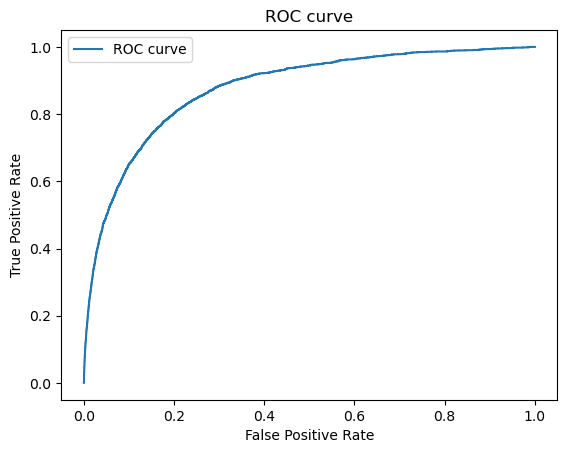

AUC: 0.87760510183906
TPR:  49.830000000000005% 
FPR:  5.0% 
Threshold:  0.03
Predictive Equality:  28.02%
Logistic Regression에서 에러 발생: cannot unpack non-iterable NoneType object


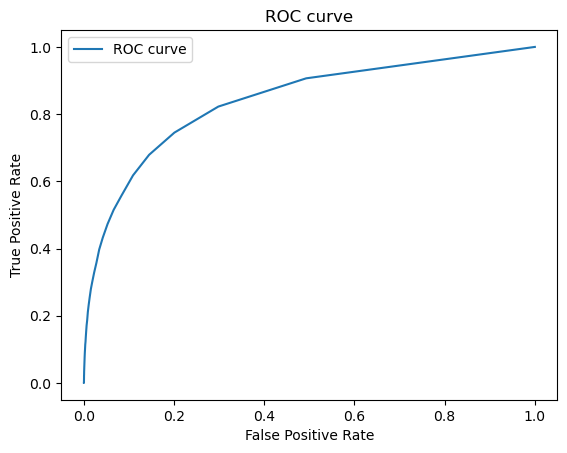

AUC: 0.8394786222380975
TPR:  43.22% 
FPR:  4.17% 
Threshold:  0.09
Predictive Equality:  37.13%
Random Forest에서 에러 발생: cannot unpack non-iterable NoneType object


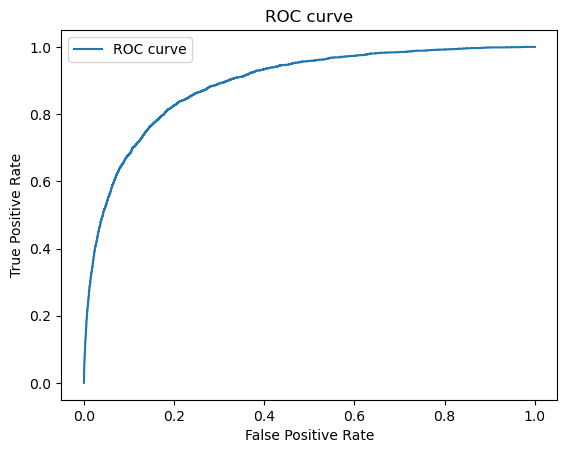

AUC: 0.8908024093645853
TPR:  53.37% 
FPR:  5.0% 
Threshold:  0.04
Predictive Equality:  27.02%
Gradient Boosting에서 에러 발생: cannot unpack non-iterable NoneType object


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 5. 모델 리스트 정의
models = [
    ("Logistic Regression", LogisticRegression(random_state=0, max_iter=1000)),
    ("Random Forest", RandomForestClassifier(random_state=0)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=0)),
    ("SVM", SVC(random_state=0, probability=True)),
    ("Decision Tree", DecisionTreeClassifier(random_state=0)),
    ("Naive Bayes", GaussianNB()),
    ('LightGBM', LGBMClassifier(boost_from_average=False)),
    ('XGBoost', XGBClassifier())
]

# 6. 모델 평가
model_results = []

for name, model in models:
    try:

        # 모델 학습 및 예측
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:,1]
        
        # 주요 지표 계산
        roc, tpr, fpr, threshold, predictive_equality = evaluate(y_pred_proba)
        
        # 결과 저장
        model_results.append((name, roc, tpr, fpr, threshold, predictive_equality))
    except Exception as e:
        print(f"{name}에서 에러 발생: {e}")

# 7. 결과 데이터프레임 생성 및 정렬
results_df = pd.DataFrame(model_results, columns=["Model", 'TPR', 'FPR', 'Threshold', 'Predictive Equality'])
results_df = results_df.sort_values(by="TPR", ascending=False)

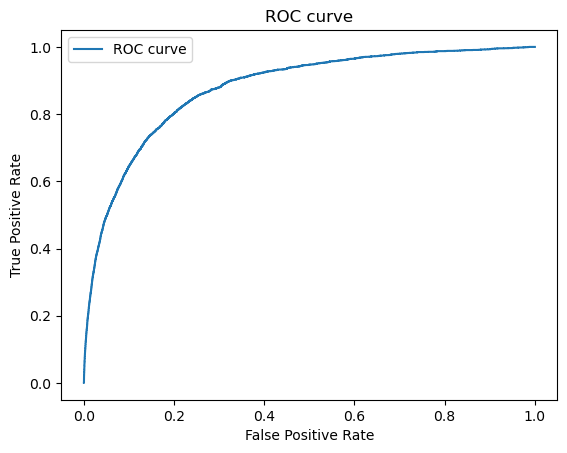

AUC: 0.8779388959897662
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%


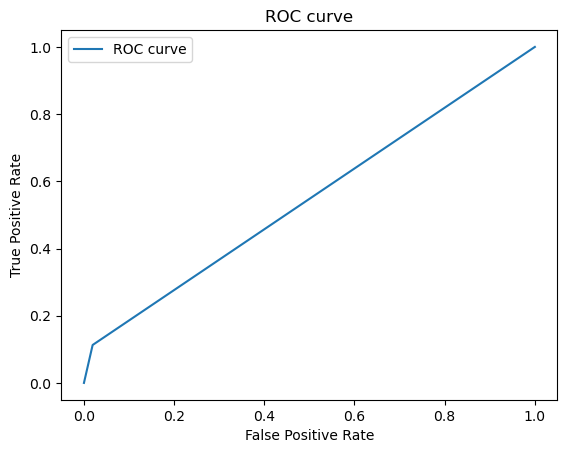

AUC: 0.5468206551073043
TPR:  11.29% 
FPR:  1.9300000000000002% 
Threshold:  1.0
Predictive Equality:  38.56%


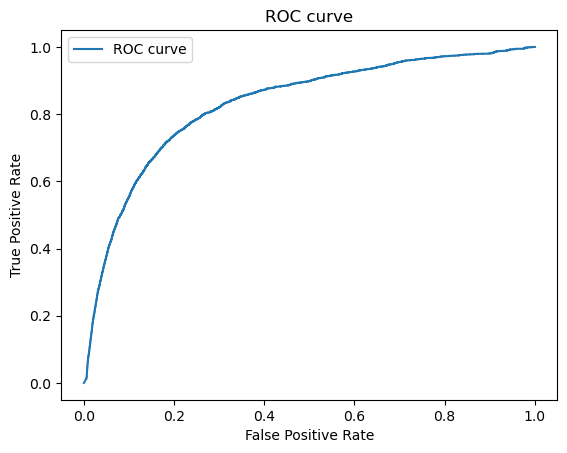

AUC: 0.830676387921153
TPR:  37.84% 
FPR:  5.0% 
Threshold:  0.99
Predictive Equality:  44.0%
[LightGBM] [Info] Number of positive: 8151, number of negative: 786838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3266
[LightGBM] [Info] Number of data points in the train set: 794989, number of used features: 50


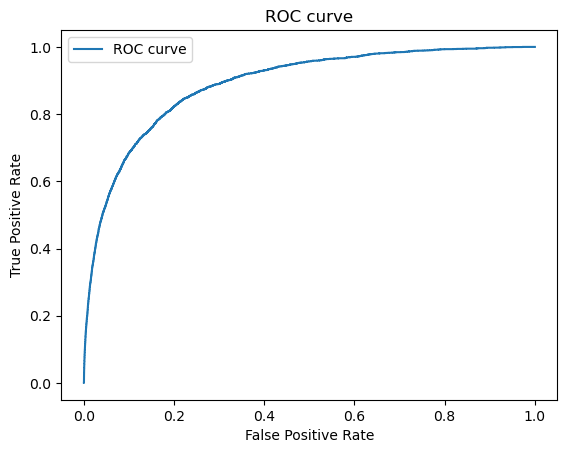

AUC: 0.8898987795508366
TPR:  53.65% 
FPR:  5.0% 
Threshold:  0.04
Predictive Equality:  29.18%


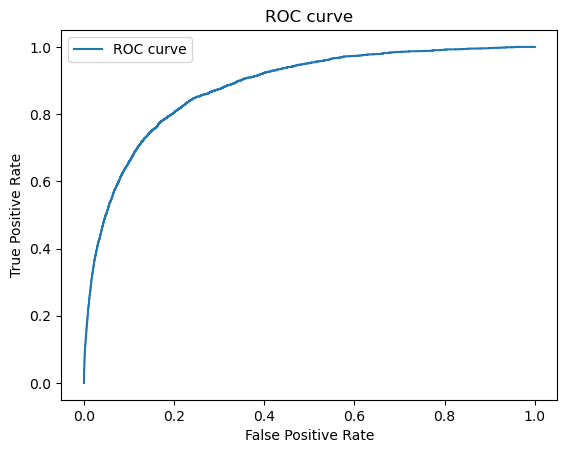

AUC: 0.882008345381496
TPR:  50.449999999999996% 
FPR:  5.0% 
Threshold:  0.04
Predictive Equality:  28.050000000000004%


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
    ("Logistic Regression", LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced')),
    ("Decision Tree", DecisionTreeClassifier(random_state=0)),
    ("Naive Bayes", GaussianNB()),
    ('LightGBM', LGBMClassifier(boost_from_average=False)),
    ('XGBoost', XGBClassifier())
]

# 6. 모델 평가
model_results = []

for name, model in models:
    try:

        # 모델 학습 및 예측
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:,1]
        
        # 주요 지표 계산
        roc, tpr, fpr, threshold, predictive_equality = evaluate(y_pred_proba)
        
        # 결과 저장
        model_results.append((name, roc, tpr, fpr, threshold, predictive_equality))
    except Exception as e:
        print(f"{name}에서 에러 발생: {e}")

# 7. 결과 데이터프레임 생성 및 정렬
results_df = pd.DataFrame(model_results, columns=["Model", 'ROC_AUC', 'TPR', 'FPR', 'Threshold', 'Predictive Equality'])
results_df = results_df.sort_values(by="TPR", ascending=False)

In [10]:
results_df

,Model,ROC_AUC,TPR,FPR,Threshold,Predictive Equality
3,LightGBM,0.889899,0.536484,0.049952,0.039429,0.291755
4,XGBoost,0.882008,0.504517,0.049987,0.039422,0.280532
0,Logistic Regression,0.877939,0.496873,0.049972,0.763167,0.895203
2,Naive Bayes,0.830676,0.378388,0.049977,0.993413,0.439980
1,Decision Tree,0.546821,0.112926,0.019284,1.000000,0.385607


In [34]:
results_df = pd.concat([results_df, pd.DataFrame({'Model': 'RandomForest','ROC_AUC': 0.8394786222380975, 'TPR':  0.4322, 'FPR':  0.0417, 'Threshold':  0.09, 'Predictive Equality':  0.3713}, index=[5])])
results_df = pd.concat([results_df, pd.DataFrame({'Model': 'Gradient Boosting','ROC_AUC': 0.8908024093645853, 'TPR':  0.5337, 'FPR':  0.05, 'Threshold':  0.04, 'Predictive Equality':  0.2702}, index=[6])])

In [35]:
results_df

,Model,ROC_AUC,TPR,FPR,Threshold,Predictive Equality
3,LightGBM,0.889899,0.536484,0.049952,0.039429,0.291755
4,XGBoost,0.882008,0.504517,0.049987,0.039422,0.280532
0,Logistic Regression,0.877939,0.496873,0.049972,0.763167,0.895203
2,Naive Bayes,0.830676,0.378388,0.049977,0.993413,0.439980
1,Decision Tree,0.546821,0.112926,0.019284,1.000000,0.385607
5,RandomForest,0.839479,0.432200,0.041700,0.090000,0.371300
6,Gradient Boosting,0.890802,0.533700,0.050000,0.040000,0.270200


In [38]:
results_df = results_df.sort_values(by="TPR", ascending=False)
results_df.drop(['FPR', 'Threshold'], axis=1)

,Model,ROC_AUC,TPR,Predictive Equality
3,LightGBM,0.889899,0.536484,0.291755
6,Gradient Boosting,0.890802,0.533700,0.270200
4,XGBoost,0.882008,0.504517,0.280532
0,Logistic Regression,0.877939,0.496873,0.895203
5,RandomForest,0.839479,0.432200,0.371300
2,Naive Bayes,0.830676,0.378388,0.439980
1,Decision Tree,0.546821,0.112926,0.385607


In [44]:
sensitive_feature = X_train['customer_age']  # 민감한 특성 예시 (성별)


In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 기본 Random Forest 모델
model = RandomForestClassifier()

# 공정성 제약 설정
fair_model = ExponentiatedGradient(model, constraints=DemographicParity())

# 모델 훈련
fair_model.fit(X_train, y_train, sensitive_features=sensitive_feature)

# 예측
y_pred_proba = fair_model.predict_proba(X_test)[:,1]

evaluate(y_pred_proba)

In [ ]:
# 데이터 정의
a = {
    'Model': ['LogisticRegression', 'Naive Bayes', 'GradientBoosting', 'LightGBM', 
              'RandomForest', 'DecisionTree', 'XGBoost'],
    'ROC_AUC': [0.871452, 0.827698, 0.818850, 0.801644, 0.788204, 0.538782, 0.696819],
    'TPR': [0.485407, 0.432592, 0.329743, 0.259555, 0.247047, 0.000000, 0.000000],
    'FPR': [0.049893, 0.049992, 0.049987, 0.049809, 0.046138, 0.000000, 0.000000],
    'Threshold': [0.472775, 0.997289, 0.999374, 0.999981, 0.970000, float('inf'), float('inf')],
    'Predictive Equality': [0.730306, 0.659293, 0.999444, 0.999774, 1.000000, 0.978994, 1.000000]
}

# DataFrame 생성
a = pd.DataFrame(a)

# 결과 출력
print(a)